In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from tkinter import *
from tkinter import filedialog
import joblib
import os
import sys
if not os.path.join(os.path.abspath(''), '../') in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))
from utils.extract_features import *
from tqdm import notebook

In [2]:
label_names = ['pause', 'rear', 'groom', 'left', 'right', 'straight']

In [3]:
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
feats_labels_file = filedialog.askopenfilename(multiple=False, title='load asoid feats labels sav')
model_file = filedialog.askopenfilename(multiple=False, title='load asoid iterX model sav')
%gui tk

2023-02-20 10:18:15.469 python[64453:3324255] +[CATransaction synchronize] called within transaction
2023-02-20 10:18:23.939 python[64453:3324255] +[CATransaction synchronize] called within transaction


In [4]:
[_, _, scalar, frames2integ] = joblib.load(feats_labels_file)
[model, train_feats, train_labels, _, _, _] = joblib.load(model_file)

/opt/anaconda3/envs/seal/lib/python3.9/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/seal/lib/python3.9/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/seal/lib/python3.9/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.1.2 when using version 1.2.1. This might lead to breakin

In [5]:
X = scalar.inverse_transform(train_feats[-1][0])
y = train_labels[-1][0]
X.shape, y.shape

((2818, 36), (2818,))

In [6]:
rf_clf = RandomForestClassifier(n_estimators=200,
                                random_state=42,
                                n_jobs=-1,
                                criterion='gini',
                                class_weight='balanced_subsample')
rf_clf.fit(X, y)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200,
                       n_jobs=-1, random_state=42)

In [7]:
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
dlc_files = filedialog.askopenfilename(multiple=True, title='load dlc csv files')
%gui tk

2023-02-20 10:18:29.599 python[64453:3324255] +[CATransaction synchronize] called within transaction


In [8]:
df_0 = pd.read_csv(dlc_files[0], header=[0, 1, 2], sep=",", index_col=0, low_memory=False)
# get rid of likelihood columns for deeplabcut
llh_cols = np.where(df_0.columns.get_level_values(2)=='likelihood')[0]
idx_selected = [i for i in np.arange(len(df_0.columns)) if i not in llh_cols]
input_pose_files = []
for dlc_file in notebook.tqdm(dlc_files):
    dlc_df = pd.read_csv(dlc_file, header=[0, 1, 2], sep=",", low_memory=False, index_col=0)
    input_pose_files.append(np.array(dlc_df.iloc[:, idx_selected]))



  0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
features_list = []
for i, data in enumerate(notebook.tqdm(input_pose_files)):
    # we are doing this to predict on each file seperatly!
    features, _ = feature_extraction([data], 1, frames2integ)
    features_list.append(features)

  0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
predictions_list = []
for features_file in features_list:
    predictions_list.append(rf_clf.predict(features_file))

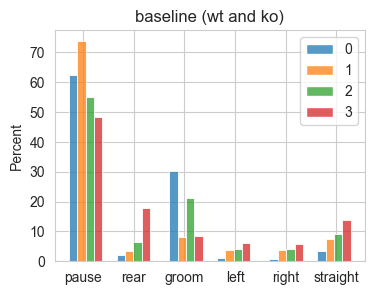

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax = sns.histplot(data=predictions_list,
                  shrink=7,
                  multiple='dodge',
                  stat = 'percent',
                  common_norm=False)
ax.set_title('baseline (wt and ko)')
ax.set_xticks(np.arange(0, len(label_names)))
ax.set_xticklabels(label_names)
# ax.set_ylim([0, 20])
plt.show()

In [34]:
bout_counts_all = []
behav_durations_all = []
for f in notebook.tqdm(np.arange(1, 4, 2)):
    bout_start_idx = np.where(np.diff(np.hstack([-1, predictions_list[f]])) != 0)[0]
    bout_durations = np.hstack([np.diff(bout_start_idx), len(predictions_list[f])-np.max(bout_start_idx)])
    bout_start_label = predictions_list[f][bout_start_idx]
    bout_counts = []
    behav_durations = []
    for b in np.unique(bout_start_label):
        idx_b = np.where(bout_start_label == int(b))[0]
        bout_counts.append(len(idx_b))
        behav_durations.append(bout_durations[idx_b])
    bout_counts_all.append(bout_counts)
    behav_durations_all.append(behav_durations)

  0%|          | 0/2 [00:00<?, ?it/s]

<AxesSubplot: >

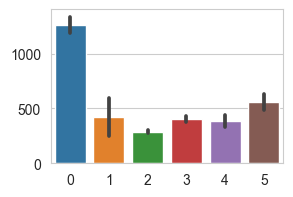

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
# ax.bar(np.arange(len(bout_counts)), bout_counts)
sns.barplot(data=np.vstack(bout_counts_all))

In [36]:
bout_counts_all = []
behav_durations_all = []
for f in notebook.tqdm(np.arange(0, 4, 2)):
    bout_start_idx = np.where(np.diff(np.hstack([-1, predictions_list[f]])) != 0)[0]
    bout_durations = np.hstack([np.diff(bout_start_idx), len(predictions_list[f])-np.max(bout_start_idx)])
    bout_start_label = predictions_list[f][bout_start_idx]
    bout_counts = []
    behav_durations = []
    for b in np.unique(bout_start_label):
        idx_b = np.where(bout_start_label == int(b))[0]
        bout_counts.append(len(idx_b))
        behav_durations.append(bout_durations[idx_b])
    bout_counts_all.append(bout_counts)
    behav_durations_all.append(behav_durations)

  0%|          | 0/2 [00:00<?, ?it/s]

<AxesSubplot: >

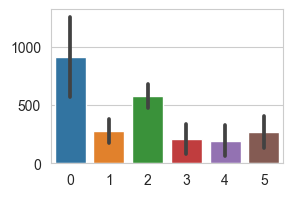

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
# ax.bar(np.arange(len(bout_counts)), bout_counts)
sns.barplot(data=np.vstack(bout_counts_all))